In [31]:
%run functions.py

import numpy as np
import pandas as pd
from scipy.io import loadmat
import pickle

from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from warnings import filterwarnings

# Task 4 - Classification 

## Load settings

In [13]:
pd.set_option('display.max_colwidth',-1)
import sys
np.set_printoptions(threshold=sys.maxsize)
filterwarnings('ignore')

k=10 # Define k for crossvalidation
seed = 42 # Seed to use
feature_tot = 0 # Total selected features -> Start at 0 before PCA
taskname = "task4"
#filedir = "/home/fredrik/Documents/Learning_Systems/Labs/Project/"
filedir = "C:/Users/fredr/Documents/github-projects/Learning_systems/Labs/Project/"

scoring='accuracy' # Scoring method for GridsearchCV
score_function = f_classif # Score function for Feature selection
verbose=10

np.random.seed(seed) # Define the random seed

In [14]:
# Define models that should be trained
estimators = [
    ('clf', 'passthrough'),
]
param_grid = [
    {
        'clf':[LinearSVC()],
        'clf__penalty':['l1','l2'],
        'clf__C': [0.1,0.5,1,1.5,2.0],
        'clf__dual':[True,False]
    },{
        'clf':[SVC()],
        'clf__C':[1,0.5,1,5.2],
        'clf__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__degree':[1,2,3],
        'clf__gamma':['scale', 'auto'],
        'clf__max_iter':[1000,5000,10000],
    },{
        'clf':[RandomForestClassifier()],
        'clf__n_estimators':[100,150,200],
    },{
        'clf':[KNeighborsClassifier()],
        'clf__n_neighbors':[5,3,6,8],
        'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'clf__leaf_size':[30,15,20,40]
    },{
        'clf':[MLPClassifier()],
        'clf__hidden_layer_sizes':[(100,20)],
        'clf__activation':['relu', 'tanh', 'logistic'],
        'clf__solver':['adam', 'lbfgs'],
        'clf__alpha':[0.0001,0.001,0.1],
        'clf__max_iter':[200,400],
        'clf__early_stopping':[True, False]
    }
]

## Load dataset

In [15]:
filename = "datasets/thyroidTrain.mat"

mat = loadmat(filename)
input_train = mat['trainThyroidInput']

target_train = mat['trainThyroidOutput']
input_test = mat['testThyroidInput']

## Data info

In [16]:
get_data_info(input_train, target_train)

Length of 5000
X.shape: (5000, 21) y.shape: (5000, 3)
Contains Nan: False False
Contains +inf: False False
Contains -inf: False False
Input: [[2.8000e-01 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.5000e-03 2.6000e-02
  1.7900e-01 1.5500e-01 1.1500e-01]
 [4.5000e-01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e-05 1.4000e-02
  1.4400e-01 9.9000e-02 1.4516e-01]] 
Target: [[0 0 1]
 [0 0 1]]


## Preprocess
Normalize the dataset

In [17]:
input_train, input_test, target_train, input_train_copy, input_train_copy_normalized = preprocessing(input_train,target_train, input_test)

One hot --> single value output
5000


## Feature reduction
Reduce dimensionality by PCA transform

In [18]:
feature_tot, pca, pca_input = feature_reduction(input_train, target_train,input_train_copy)

original shape:    (5000, 21)
transformed shape: (5000, 19)
Explained variance: [0.11644462 0.07693855 0.06624585 0.05484826 0.05400037 0.05290859
 0.04951334 0.04840626 0.04679861 0.04582658 0.04538423 0.04431255
 0.04244733 0.04194532 0.04107869 0.04019269 0.03850317 0.03597675
 0.03242482]


# Feature extraction

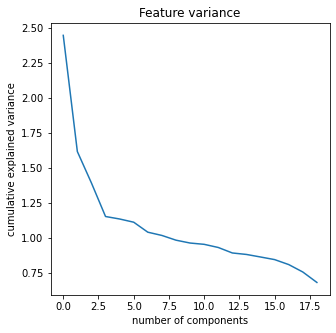

In [19]:
plot_feature_variance(pca_input, filedir=filedir, taskname=taskname)

## Plot top 10 histogram over reduced features

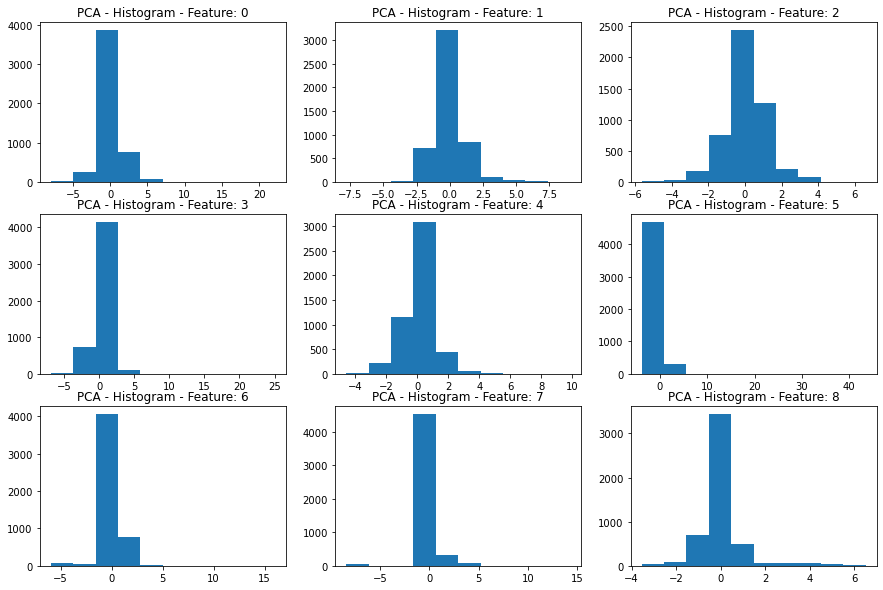

In [20]:
plot_top_features(feature_tot,pca_input, filedir=filedir, taskname=taskname)

# Feature selection
Extract top features above depending on PCA

(5000, 21)


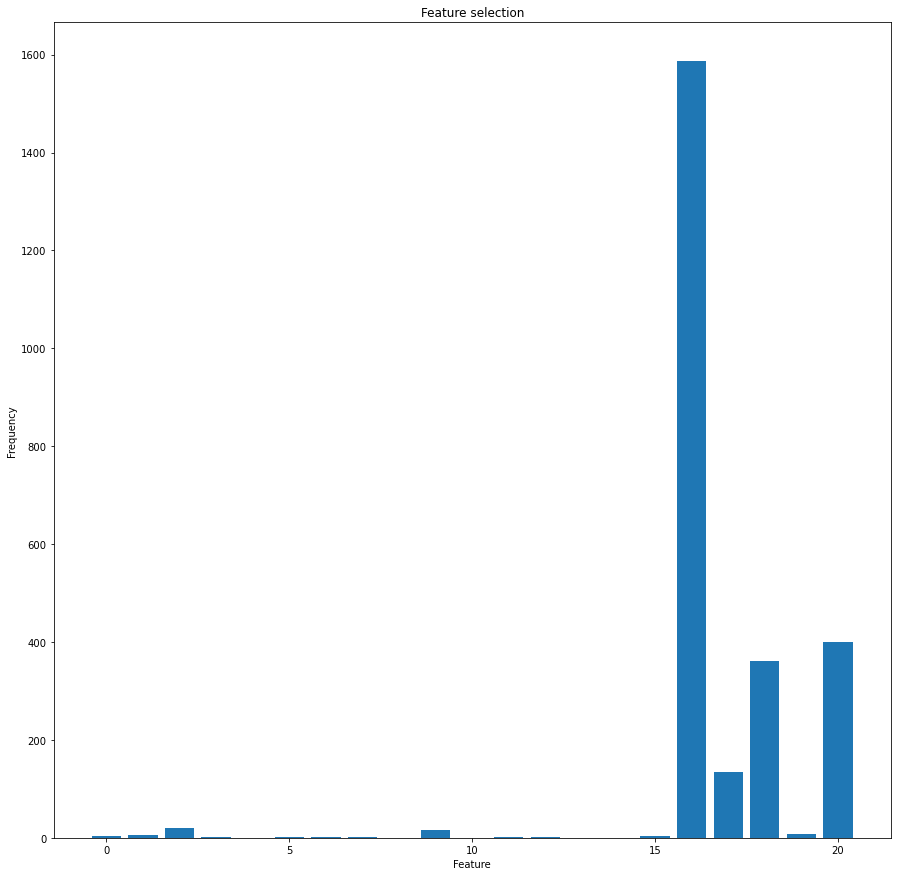

In [21]:
input_train_fs, input_test_fs = feature_selection(score_function, input_train, target_train, input_test, filedir=filedir, taskname=taskname, feature_tot=feature_tot)

## Hyperparameter tuning

In [22]:
# GridSearchCV
grid = parameter_tuning(estimators, param_grid, input_train_fs, target_train, scoring=scoring, k=k)


Fitting 10 folds for each of 447 candidates, totalling 4470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 4470 out of 4470 | elapsed: 32.4min finished


## Save model

In [23]:
save_model(grid, filedir=filedir, taskname=taskname)

Save model into: C:/Users/fredr/Documents/github-projects/Learning_systems/Labs/Project/Models/task4.joblib


## Load model

In [24]:
if not grid: 
    grid = load_model(filedir=filedir, taskname=taskname)

## Get Model info

In [25]:
get_model_info(grid)

Best score: 0.9954000000000001
Best params {'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'clf__n_estimators': 100}

                                                                                                                                                                                                                                                                                                                                                                                      

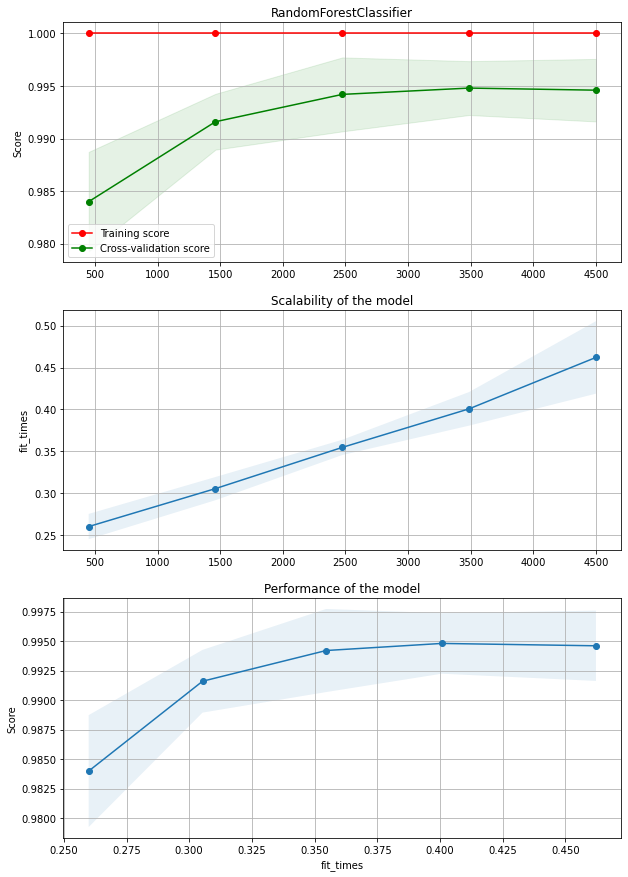

In [26]:
validate_curve(grid, input_train_fs, target_train,filedir=filedir, taskname=taskname,scoring=scoring, k=k)

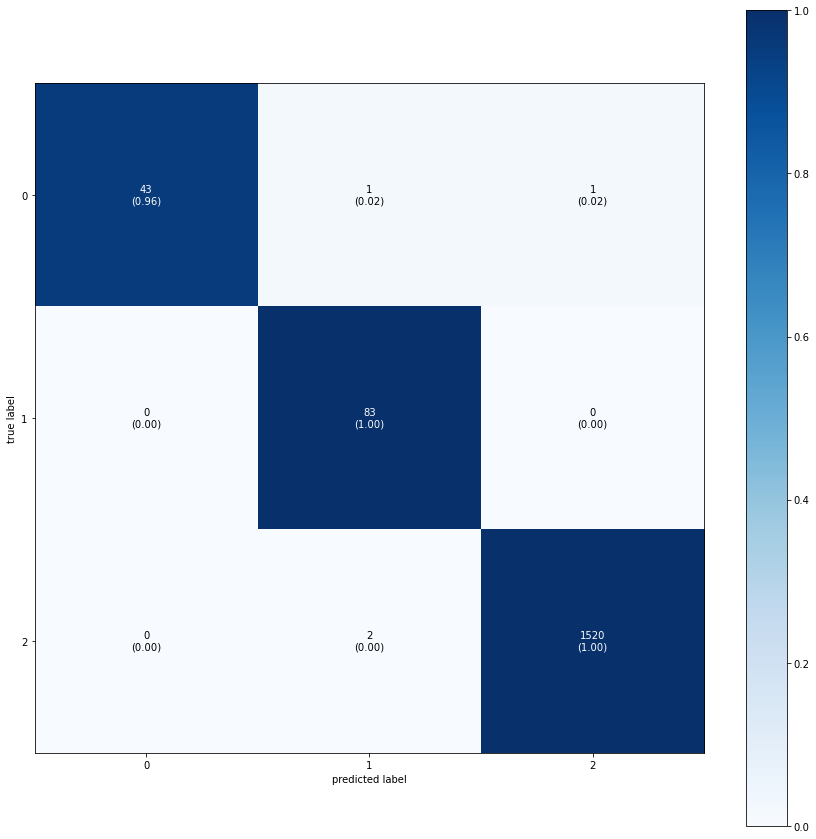

In [27]:
display_confusion_matrix(grid, input_train_fs, target_train, filedir=filedir, taskname=taskname)

# Predict testset

In [32]:
_,predict = predict_model(grid, input_train_fs, target_train, input_test_fs)
save_prediction(predict, filedir, taskname)
print(predict)

[2 2 2 2 2 2 1 0 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 1 2 2 2 2 2 1 0 2 2 2 2 2 1 2 0 0 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 1 2 2 1 2 1 2 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 